In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Cleaning

In [5]:
months = ['January', 'February', 'March',
          'April', 'May', 'June', 'July',
          'August', 'September', 'October',
          'November', 'December']
def classify_month(x):
    return months.index(x) // 3

from nltk import word_tokenize
from nltk import pos_tag

keys = np.unique(np.concatenate([train['Property_type'],test['Property_type']]))
vals = [[w[0] for w in pos_tag([word for word in word_tokenize(doc.lower().replace('/',' ')) if word.isalpha()]) if w[1] == 'NN' and w[0] != 'room'] for doc in keys]
uni_vals = np.unique(['room'] + [' '.join(v) for v in vals])

val_dict = {}
for i, v in enumerate(uni_vals):
    val_dict[v] = i

property_dict = {}
for i, k in enumerate(keys):
    if len(vals[i]) == 0:
        property_dict[k] = val_dict['room']
    else:
        property_dict[k] = val_dict[' '.join(vals[i])]

#property_dict

def clean_bathroom(X):
    clean = [[w[0] for w in pos_tag(word_tokenize(doc.lower())) if w[1] == 'CD' or w[1] == 'NN' or w[1] == 'NNS'] for doc in X]
    return [0.5 if len(doc) == 1 else doc[0] for doc in clean] #map half-bath to 0.5

key = np.concatenate([train['Bathrooms_text'].unique(), test['Bathrooms_text'].unique()])
bath = clean_bathroom(key)

bath_dict = {}
for i, k in enumerate(key):
    bath_dict[k] = bath[i]

#bath_dict

def CLEAN_ALL(inp, train = True, exclude_columns = ['id']):
    X_train = inp.copy()
    
    if train:
        X_train, y_train = X_train.drop('Decision', axis = 1), X_train['Decision']

    # DATA CLEANING
    if 'Price' not in exclude_columns:
        X_train['Price'] = X_train['Price'].apply(lambda x: float(x.replace('$','').replace(',','')))
        
    if 'Host_response_time' not in exclude_columns:
        X_train['Host_response_time'] = X_train['Host_response_time'].apply(lambda x: 0 if x == 'within an hour' else (1 if x == 'within a few hours' else (2 if x == 'within a day' else (3 if x == 'a few days or more' else x))))
    
    if 'Host_is_superhost' not in exclude_columns:
        X_train['Host_is_superhost'] = X_train['Host_is_superhost'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Host_has_profile_pic' not in exclude_columns:
        X_train['Host_has_profile_pic'] = X_train['Host_has_profile_pic'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Host_identity_verified' not in exclude_columns:
        X_train['Host_identity_verified'] = X_train['Host_identity_verified'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Instant_bookable' not in exclude_columns:
        X_train['Instant_bookable'] = X_train['Instant_bookable'].apply(lambda x: 1 if x == 't' else (0 if x == 'f' else x))
    
    if 'Bathrooms_text' not in exclude_columns:
        X_train['Bathrooms_text'] = X_train['Bathrooms_text'].apply(lambda x: float(bath_dict[x]))

    if 'Property_type' not in exclude_columns:
        X_train['Property_type'] = X_train['Property_type'].apply(lambda x: property_dict[x])
    
    if 'Room_type' not in exclude_columns:
        X_train['Room_type'] = X_train['Room_type'].apply(lambda x: 0 if x == 'Entire home/apt' else (1 if x == 'Private room' else (2 if x == 'Hotel room' else 3)))

    if 'Month' not in exclude_columns:
        X_train['Month'] = X_train['Month'].apply(lambda x: classify_month(x))
    
    for col in exclude_columns:
        X_train = X_train.drop(col, axis = 1)
        
    if train:
        return X_train, y_train
    else:
        return X_train
    
#X, y = CLEAN_ALL(train)

In [6]:
# Clean data
pipeline = make_pipeline(KNNImputer(n_neighbors = 10), StandardScaler())
X,y = CLEAN_ALL(train)
X = pipeline.fit_transform(X)

# Cross Validation over Gamma

In [16]:
g_accs = np.zeros((10, 5))
for i, g in enumerate(tqdm([1, 2, 3, 5, 10, 15, 20, 25, 100, 1000])):
    est = SVC(kernel = 'rbf', gamma = 1/g)
    cv_results = cross_validate(est, X, y)
    g_accs[i] = cv_results['test_score']

100%|██████████| 10/10 [01:19<00:00,  7.94s/it]


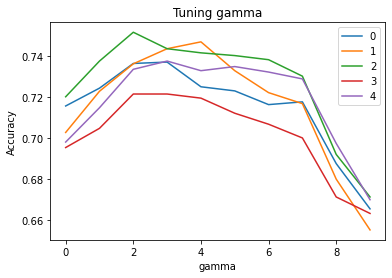

In [17]:
plt.plot(range(10), g_accs)
plt.legend(range(5))
plt.title('Tuning gamma')
plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.show()

# Cross Validation over Regularization

In [22]:
c_accs = np.zeros((5, 5))
for i, c in enumerate(tqdm([1, 10, 100, 1000, 10000])):
    est = SVC(kernel = 'rbf', gamma = 1/5, C = c)
    cv_results = cross_validate(est, X, y)
    c_accs[i] = cv_results['test_score']

100%|██████████| 5/5 [00:56<00:00, 11.20s/it]


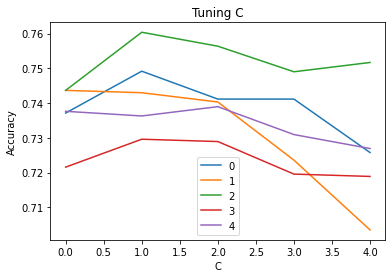

In [23]:
plt.plot(range(5), c_accs)
plt.legend(range(5))
plt.title('Tuning C')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

# Final Model

In [27]:
est = SVC(kernel = 'rbf', gamma = 1/5, C = 10)
cv_results = cross_validate(est, X, y, return_estimator = True)
print(cv_results['test_score'])

[0.74916388 0.74297189 0.76037483 0.72958501 0.73627845]


In [30]:
model = cv_results['estimator'][2]

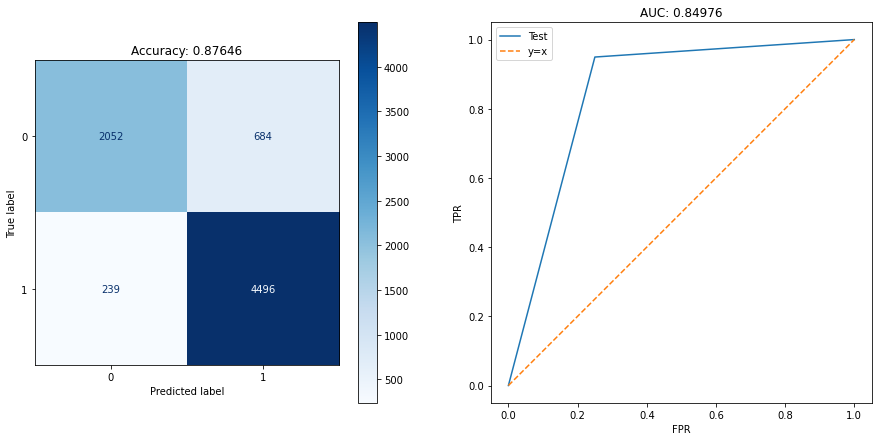

In [46]:
fig, axs = plt.subplots(1, 2, figsize = (15, 7))

test_pred = model.predict(X)
cm = confusion_matrix(y, test_pred, labels = model.classes_)#, normalize = 'true')
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = model.classes_
)
disp.plot(cmap =  plt.cm.Blues, ax = axs[0])

axs[0].set(title = 'Accuracy: ' + str(round(np.sum(test_pred == y)/len(y),5)))

te_fpr, te_tpr, thresh = roc_curve(y, test_pred)

axs[1].plot(te_fpr, te_tpr)
axs[1].plot([0,1],[0,1],'--')
axs[1].legend(labels = ['Test', 'y=x'])
axs[1].set(title = 'AUC: ' + str(round(auc(te_fpr, te_tpr), 5)), 
           xlabel = 'FPR', ylabel = 'TPR')

plt.show()

In [41]:
import csv

In [43]:
testX = CLEAN_ALL(test, train = False)
testX = pipeline.fit_transform(testX)
pred = model.predict(testX)

In [44]:
with open('submission.csv', 'w') as sub:
    writer = csv.writer(sub, delimiter=',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'Decision'])
    for i in range(len(pred)):
        writer.writerow([int(test['id'].values[i]), pred[i]])